## Notebook for loan dataset

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn. neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


### Import data

In [2]:
data = pd.read_csv("data/loan_data/loan-10k.lrn.csv", sep=",")
df_final_test  = pd.read_csv("data/loan_data/loan-10k.tes.csv")

In [3]:
data.head()

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,...,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,...,N,10,2015,9,1984,2,2019,2,2019,E
2,35080,10000.0,10000.0,10000.0,60 months,20.00,264.94,< 1 year,RENT,36580.0,...,N,9,2017,10,2006,1,2018,11,2018,D
3,4828,20250.0,20250.0,20250.0,36 months,14.31,695.15,9 years,RENT,48700.0,...,N,0,2015,6,1996,6,2016,9,2017,C
4,59259,25000.0,25000.0,25000.0,36 months,14.99,866.52,1 year,MORTGAGE,85000.0,...,N,11,2016,0,2002,2,2019,2,2019,C


In [4]:
data.shape

(10000, 92)

In [5]:
df_final_test.head()

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,3582,10000.0,10000.0,10000.0,36 months,9.93,322.35,< 1 year,MORTGAGE,130000.0,...,Cash,N,9,2017,8,2006,2,2019,2,2019
1,60498,20000.0,20000.0,20000.0,60 months,13.67,461.96,10+ years,MORTGAGE,75500.0,...,Cash,N,3,2016,3,2002,0,2018,2,2019
2,53227,15000.0,15000.0,15000.0,36 months,11.80,496.79,< 1 year,RENT,38000.0,...,Cash,N,11,2018,9,2004,2,2019,2,2019
3,21333,12500.0,12500.0,12500.0,36 months,15.31,435.22,10+ years,MORTGAGE,65000.0,...,Cash,N,4,2013,10,1996,4,2016,2,2018
4,3885,19000.0,19000.0,19000.0,60 months,27.88,590.21,6 years,MORTGAGE,38000.0,...,Cash,N,10,2015,1,2001,4,2016,2,2019


### Data exploration

In [6]:
# set ID column as index
data_index = data["ID"]
data.set_index("ID", inplace=True)

final_test_index = df_final_test["ID"]
df_final_test.set_index("ID", inplace=True)

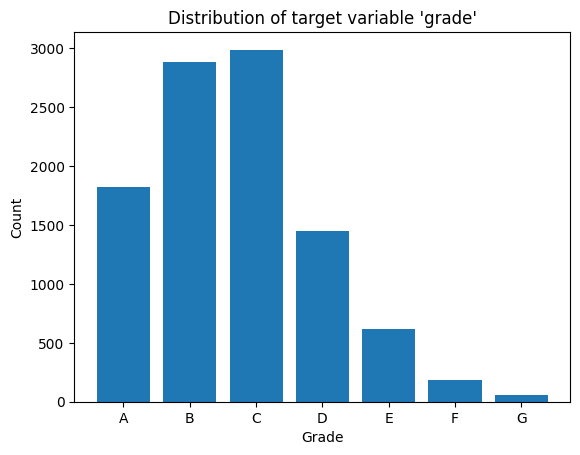

In [7]:
# distribution of target variable

target_distr = data["grade"].value_counts().sort_index()

plt.bar(target_distr.index, target_distr)
plt.title("Distribution of target variable 'grade'")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

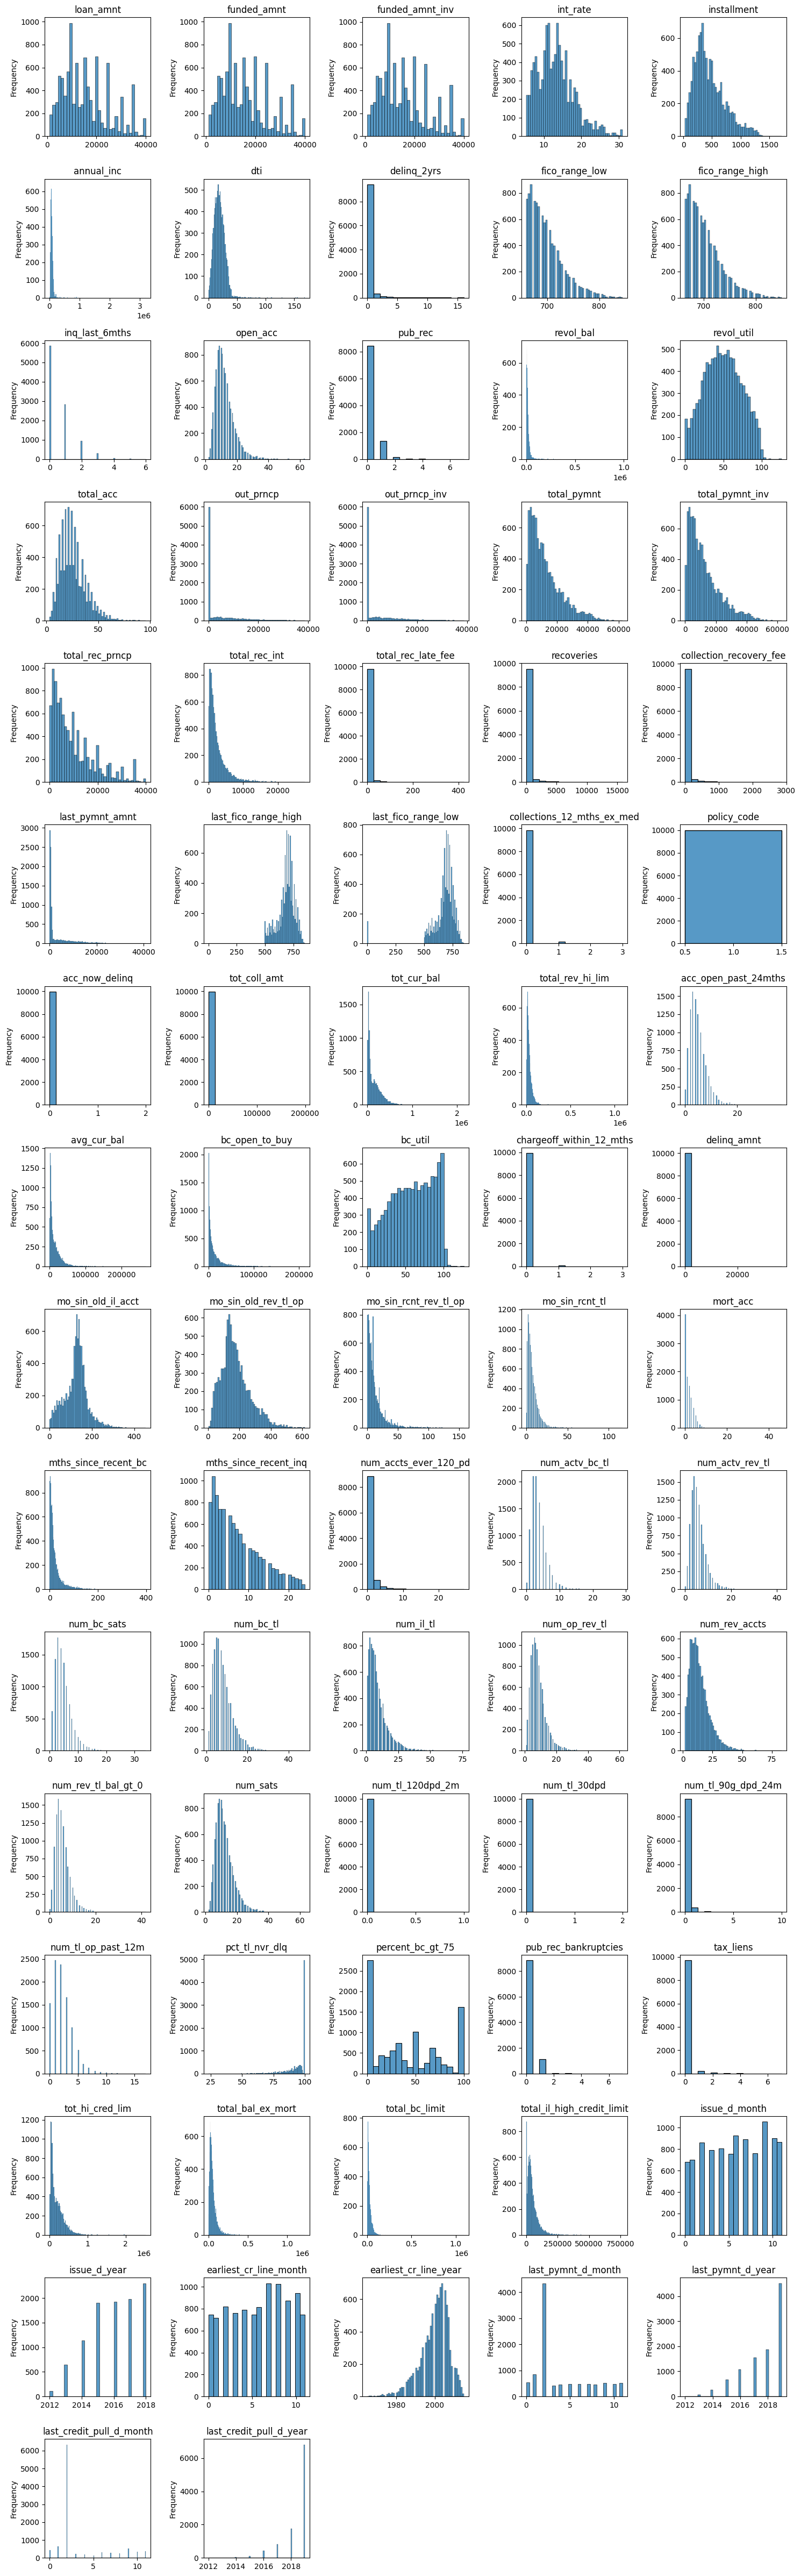

In [8]:
numerical_data = data.select_dtypes(include=["number"])

n_cols = numerical_data.shape[1]

nrows_plot = int(np.ceil(n_cols / 5))
ncols_plot = 5

fig, axes = plt.subplots(nrows=nrows_plot, ncols=ncols_plot, figsize=(15, nrows_plot * 3))
axes = axes.flatten()

for i, col in enumerate(numerical_data.columns):
    sns.histplot(numerical_data[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")


for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [9]:
# encode target variable
label_encoder = LabelEncoder()
data["grade"] = label_encoder.fit_transform(data["grade"])

In [10]:
# encode columns with dtype object/string as dummy variables
categorical_data = data.select_dtypes(include=["object"])

# instantiate OneHotEncoder
oh_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop="first")
categorical_data_encoded = oh_encoder.fit_transform(categorical_data)

# prepare for merging
encoded_col_names = oh_encoder.get_feature_names_out(categorical_data.columns)
categorical_data_encoded = pd.DataFrame(categorical_data_encoded, columns=encoded_col_names)
categorical_data_encoded["ID"] = data_index
categorical_data_encoded.set_index("ID", inplace=True)

numerical_data = data.select_dtypes(include=["number"])

# combine dummy-encoded variables again with numerical variables
data_encoded = pd.concat([numerical_data, categorical_data_encoded], axis=1)

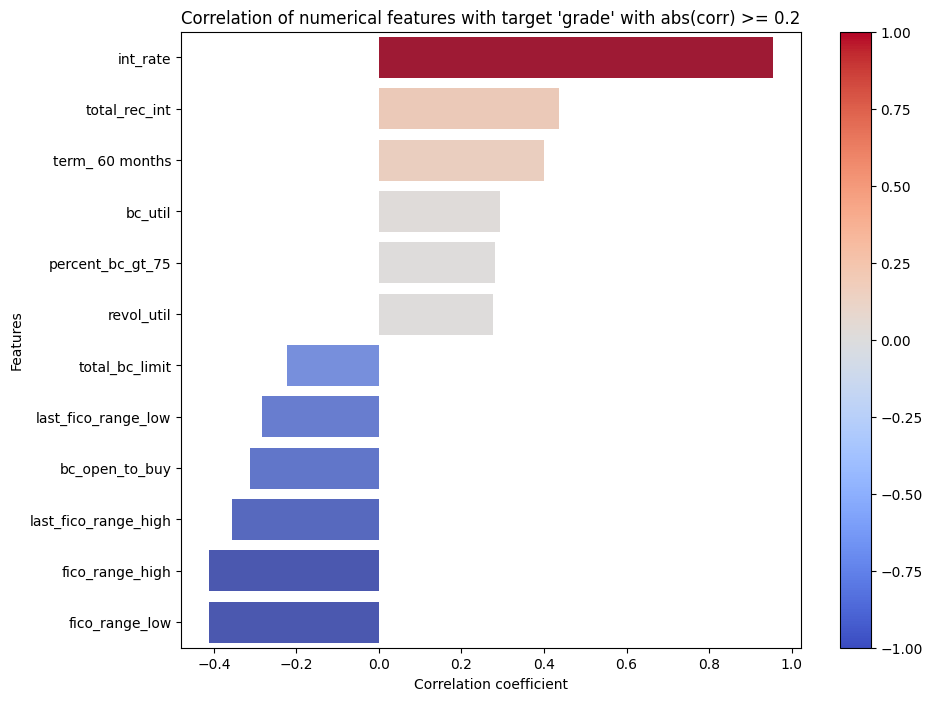

In [11]:
numerical_data = data_encoded.select_dtypes(include=["number"])

# Compute correlation matrix & filter for columns greater than 0.2
corr_matrix = numerical_data.corr()["grade"].drop("grade")
corr_matrix_filtered = corr_matrix[corr_matrix.abs() >= 0.2]

# Sort by absolute correlation value
corr_matrix_sorted = corr_matrix_filtered.sort_values(ascending=False)

plt.figure(figsize=(10, 8))

norm = plt.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

ax = sns.barplot(x=corr_matrix_sorted.values, y=corr_matrix_sorted.index, palette="coolwarm", hue=corr_matrix_sorted.values)
ax.set_title("Correlation of numerical features with target 'grade' with abs(corr) >= 0.2")
ax.set_xlabel("Correlation coefficient")
ax.set_ylabel("Features")
ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)

plt.show()

### Train/Test Split

In [12]:
X = data_encoded.drop("grade", axis=1)
y = data_encoded["grade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Check for missing values in train data & kaggle test set

In [13]:
# Check for missing values in train data

# Check if there are any missing values
has_null = data_encoded.isna().values.any()

# Print total number of missing values
total_null = data_encoded.isna().sum().sum()

print(f"The train dataset has null values: {has_null}")
print(f"The train dataset has {total_null} null values")

The train dataset has null values: False
The train dataset has 0 null values


In [14]:
# Check for missing values in test data

# Check if there are any missing values
has_null = df_final_test.isna().values.any()

# Print total number of missing values
total_null = df_final_test.isna().sum().sum()

print(f"The kaggle test dataset has null values: {has_null}")
print(f"The kaggle test dataset has {total_null} null values")

The kaggle test dataset has null values: False
The kaggle test dataset has 0 null values


### 1. Experiment: Base Model with default parameters / Holdout

In [17]:
# KNN classifier

knn = KNeighborsClassifier()
start_time = time.time()
knn.fit(X_train, y_train)
end_time = time.time()

y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred, normalize=True)
f1  = f1_score(y_test, y_pred, average="macro")
training_time = end_time - start_time

print(f"Accuracy: {acc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Training Time KNN: {training_time:.4f} seconds")

Accuracy: 0.30
F1 Score: 0.17
Training Time KNN: 0.0273 seconds


In [18]:
# Random Forest classifier

rand_forest = RandomForestClassifier(random_state=42)
start_time = time.time()
rand_forest.fit(X_train, y_train)
end_time = time.time()

y_pred = rand_forest.predict(X_test)

acc = accuracy_score(y_test, y_pred, normalize=True)
f1  = f1_score(y_test, y_pred, average="macro")
training_time = end_time - start_time

print(f"Accuracy: {acc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Training Time Random Forest: {training_time:.4f} seconds")

Accuracy: 0.81
F1 Score: 0.50
Training Time Random Forest: 3.0309 seconds


In [19]:
# Multi Layer Perceptron

mlp = MLPClassifier(random_state=42)
start_time = time.time()
mlp.fit(X_train, y_train)
end_time = time.time()

y_pred = mlp.predict(X_test)

acc = accuracy_score(y_test, y_pred, normalize=True)
f1  = f1_score(y_test, y_pred, average="macro")
training_time = end_time - start_time

print(f"Accuracy: {acc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Training Time MLP: {training_time:.4f} seconds")

Accuracy: 0.44
F1 Score: 0.29
Training Time MLP: 3.2890 seconds


### 2. Experiment: Compare Holdout to CV

In [22]:
# CV for KNN
start_time = time.time()
cv_scores_knn = cross_val_score(knn, X_train, y_train, cv=5)
end_time = time.time()

mean_cv_score  = cv_scores_knn.mean()
training_time = end_time - start_time

print(f"Average accuracy across all folds: {mean_cv_score}")
print(f"Training Time CV: {training_time:.4f} seconds")

Average accuracy across all folds: 0.319875
Training Time CV: 0.7692 seconds


In [23]:
# CV for Random Forest
start_time = time.time()
cv_scores_rand_forest = cross_val_score(rand_forest, X_train, y_train, cv=5)
end_time = time.time()

mean_cv_score  = cv_scores_rand_forest.mean()
training_time = end_time - start_time

print(f"Average accuracy across all folds: {mean_cv_score}")
print(f"Training Time CV: {training_time:.4f} seconds")

Average accuracy across all folds: 0.8140000000000001
Training Time CV: 11.7399 seconds


In [24]:
# CV for Multi Layer Perceptron
start_time = time.time()
cv_scores_mlp = cross_val_score(mlp, X_train, y_train, cv=5)
end_time = time.time()

mean_cv_score  = cv_scores_mlp.mean()
training_time = end_time - start_time

print(f"Average accuracy across all folds: {mean_cv_score}")
print(f"Training Time CV: {training_time:.4f} seconds")

Average accuracy across all folds: 0.43725
Training Time CV: 22.7105 seconds


### 3. Experiment: Compare Scaling vs. No Scaling

In [25]:
standard_scaler = StandardScaler()
X_train_standard_scaled = standard_scaler.fit_transform(X_train)
X_test_standard_scaled = standard_scaler.transform(X_test)

min_max_scaler = MinMaxScaler()
X_train_minmax_scaled = min_max_scaler.fit_transform(X_train)
X_test_minmax_scaled = min_max_scaler.transform(X_test)

robust_scaler = RobustScaler()
X_train_robust_scaled = robust_scaler.fit_transform(X_train)
X_test_robust_scaled = robust_scaler.transform(X_test)

In [26]:
knn_standard = KNeighborsClassifier()
knn_minmax   = KNeighborsClassifier()
knn_robust   = KNeighborsClassifier()

start_time = time.time()
knn_standard.fit(X_train_standard_scaled, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time with standard scaled data: {training_time}")

start_time = time.time()
knn_minmax.fit(X_train_minmax_scaled, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time with minmax scaled data: {training_time}")

start_time = time.time()
knn_robust.fit(X_train_robust_scaled, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time with robust scaled data: {training_time}")

y_pred_standard = knn_standard.predict(X_test_standard_scaled)
y_pred_minmax   = knn_minmax.predict(X_test_minmax_scaled)
y_pred_robust   = knn_robust.predict(X_test_robust_scaled)

acc_standard = accuracy_score(y_test, y_pred_standard, normalize=True)
acc_minmax   = accuracy_score(y_test, y_pred_minmax, normalize=True)
acc_robust   = accuracy_score(y_test, y_pred_robust, normalize=True)

f1_standard  = f1_score(y_test, y_pred_standard, average="macro")
f1_minmax    = f1_score(y_test, y_pred_minmax, average="macro")
f1_robust    = f1_score(y_test, y_pred_robust, average="macro")

print(f"Accuracy standard scaled: {acc_standard:.2f}")
print(f"Accuracy minmax scaled: {acc_minmax:.2f}")
print(f"Accuracy robust scaled: {acc_robust:.2f}")

print(f"F1 Score standard scaled: {f1_standard:.2f}")
print(f"F1 Score minmax scaled: {f1_minmax:.2f}")
print(f"F1 Score robust scaled: {f1_robust:.2f}")

Training time with standard scaled data: 0.011499643325805664
Training time with minmax scaled data: 0.014673233032226562
Training time with robust scaled data: 0.01048135757446289
Accuracy standard scaled: 0.35
Accuracy minmax scaled: 0.36
Accuracy robust scaled: 0.40
F1 Score standard scaled: 0.20
F1 Score minmax scaled: 0.24
F1 Score robust scaled: 0.24


In [28]:
rand_forest_standard = RandomForestClassifier(random_state=42)
rand_forest_minmax   = RandomForestClassifier(random_state=42)
rand_forest_robust   = RandomForestClassifier(random_state=42)

start_time = time.time()
rand_forest_standard.fit(X_train_standard_scaled, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time with standard scaled data: {training_time}")

start_time = time.time()
rand_forest_minmax.fit(X_train_minmax_scaled, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time with minmax scaled data: {training_time}")

start_time = time.time()
rand_forest_robust.fit(X_train_robust_scaled, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time with robust scaled data: {training_time}")

y_pred_standard = rand_forest_standard.predict(X_test_standard_scaled)
y_pred_minmax   = rand_forest_minmax.predict(X_test_minmax_scaled)
y_pred_robust   = rand_forest_robust.predict(X_test_robust_scaled)

acc_standard = accuracy_score(y_test, y_pred_standard, normalize=True)
acc_minmax   = accuracy_score(y_test, y_pred_minmax, normalize=True)
acc_robust   = accuracy_score(y_test, y_pred_robust, normalize=True)

f1_standard  = f1_score(y_test, y_pred_standard, average="macro")
f1_minmax    = f1_score(y_test, y_pred_minmax, average="macro")
f1_robust    = f1_score(y_test, y_pred_robust, average="macro")

print(f"Accuracy standard scaled: {acc_standard:.2f}")
print(f"Accuracy minmax scaled: {acc_minmax:.2f}")
print(f"Accuracy robust scaled: {acc_robust:.2f}")

print(f"F1 Score standard scaled: {f1_standard:.2f}")
print(f"F1 Score minmax scaled: {f1_minmax:.2f}")
print(f"F1 Score robust scaled: {f1_robust:.2f}")

Training time with standard scaled data: 3.020138740539551
Training time with minmax scaled data: 2.914555311203003
Training time with robust scaled data: 2.868299961090088
Accuracy standard scaled: 0.81
Accuracy minmax scaled: 0.81
Accuracy robust scaled: 0.81
F1 Score standard scaled: 0.50
F1 Score minmax scaled: 0.50
F1 Score robust scaled: 0.50


In [29]:
mlp_standard = MLPClassifier(random_state=42)
mlp_minmax   = MLPClassifier(random_state=42)
mlp_robust   = MLPClassifier(random_state=42)

start_time = time.time()
mlp_standard.fit(X_train_standard_scaled, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time with standard scaled data: {training_time}")

start_time = time.time()
mlp_minmax.fit(X_train_minmax_scaled, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time with minmax scaled data: {training_time}")

start_time = time.time()
mlp_robust.fit(X_train_robust_scaled, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time with robust scaled data: {training_time}")

y_pred_standard = mlp_standard.predict(X_test_standard_scaled)
y_pred_minmax   = mlp_minmax.predict(X_test_minmax_scaled)
y_pred_robust   = mlp_robust.predict(X_test_robust_scaled)

acc_standard = accuracy_score(y_test, y_pred_standard, normalize=True)
acc_minmax   = accuracy_score(y_test, y_pred_minmax, normalize=True)
acc_robust   = accuracy_score(y_test, y_pred_robust, normalize=True)

f1_standard  = f1_score(y_test, y_pred_standard, average="macro")
f1_minmax    = f1_score(y_test, y_pred_minmax, average="macro")
f1_robust    = f1_score(y_test, y_pred_robust, average="macro")

print(f"Accuracy standard scaled: {acc_standard:.2f}")
print(f"Accuracy minmax scaled: {acc_minmax:.2f}")
print(f"Accuracy robust scaled: {acc_robust:.2f}")

print(f"F1 Score standard scaled: {f1_standard:.2f}")
print(f"F1 Score minmax scaled: {f1_minmax:.2f}")
print(f"F1 Score robust scaled: {f1_robust:.2f}")

Training time with standard scaled data: 15.569647073745728


c:\Users\ckand\Documents\TU Wien\Machine Learning\Exercise 0\MachineLearningCourse\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time with minmax scaled data: 18.342788457870483
Training time with robust scaled data: 4.5614914894104
Accuracy standard scaled: 0.77
Accuracy minmax scaled: 0.81
Accuracy robust scaled: 0.73
F1 Score standard scaled: 0.61
F1 Score minmax scaled: 0.71
F1 Score robust scaled: 0.53


### 4. Experiment: Feature Selection based on correlations to target variable

In [30]:
numerical_data = data_encoded.select_dtypes(include=["number"])

# Compute correlation matrix & filter for columns greater than +-0.4
corr_matrix = numerical_data.corr()["grade"].drop("grade")
corr_matrix_filtered = corr_matrix[corr_matrix.abs() >= 0.4]

# Sort by absolute correlation value
corr_matrix_sorted = corr_matrix_filtered.sort_values(ascending=False)
corr_matrix_sorted

int_rate           0.954755
total_rec_int      0.436866
term_ 60 months    0.400138
fico_range_high   -0.410915
fico_range_low    -0.410920
Name: grade, dtype: float64

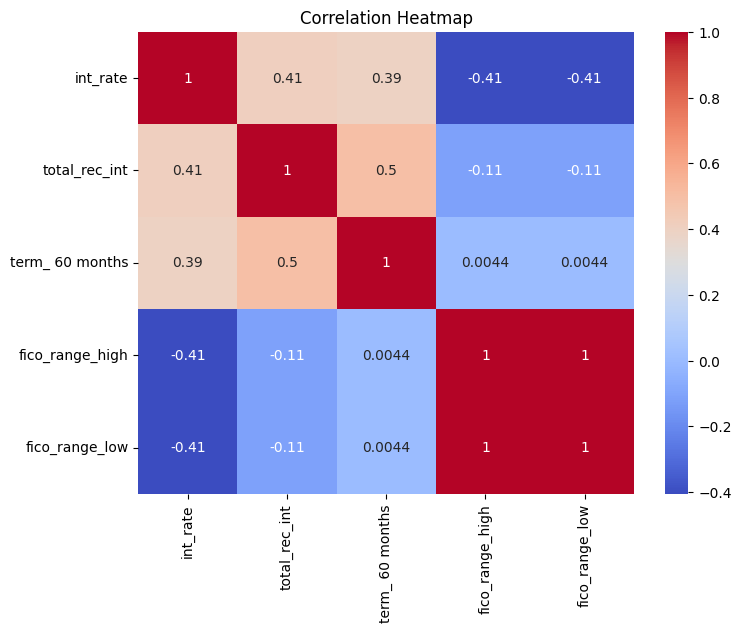

In [31]:
# before finally choosing the features, we will first check for multicollinearity between the features that correlate highly with the target variable
numerical_data = data_encoded.select_dtypes(include=["number"])

corr_matrix_feat_selection = numerical_data.corr().loc[["int_rate", "total_rec_int", "term_ 60 months", "fico_range_high", "fico_range_low"], 
                          ["int_rate", "total_rec_int", "term_ 60 months", "fico_range_high", "fico_range_low"]]

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_feat_selection, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [32]:
# since "fico_range_high" and "fico_range_low" are perfectly correlated to each other (value of 1), 
# we only include one of them in our selected feaatures in order to not introduce any multicollinearity
X_train_feature_selection = X_train[["int_rate", "total_rec_int", "term_ 60 months", "fico_range_high"]]
X_test_feature_selection  = X_test[["int_rate", "total_rec_int", "term_ 60 months", "fico_range_high"]]

In [34]:
knn_feature_selection = KNeighborsClassifier()
start_time = time.time()
knn_feature_selection.fit(X_train_feature_selection, y_train)
end_time = time.time()

y_pred = knn_feature_selection.predict(X_test_feature_selection)

acc = accuracy_score(y_test, y_pred, normalize=True)
f1  = f1_score(y_test, y_pred, average="macro")
training_time = end_time - start_time

print(f"Accuracy: {acc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Training time: {training_time}")

Accuracy: 0.41
F1 Score: 0.27
Training time: 0.009853363037109375


In [35]:
rand_forest_feature_selection = RandomForestClassifier(random_state=42)
start_time = time.time()
rand_forest_feature_selection.fit(X_train_feature_selection, y_train)
end_time = time.time()

y_pred = rand_forest_feature_selection.predict(X_test_feature_selection)

acc = accuracy_score(y_test, y_pred, normalize=True)
f1  = f1_score(y_test, y_pred, average="macro")
training_time = end_time - start_time

print(f"Accuracy: {acc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Training time: {training_time}")

Accuracy: 0.92
F1 Score: 0.84
Training time: 0.7233095169067383


In [36]:
mlp_feature_selection = MLPClassifier(random_state=42)
start_time = time.time()
mlp_feature_selection.fit(X_train_feature_selection, y_train)
end_time = time.time()

y_pred = mlp_feature_selection.predict(X_test_feature_selection)

acc = accuracy_score(y_test, y_pred, normalize=True)
f1  = f1_score(y_test, y_pred, average="macro")
training_time = end_time - start_time

print(f"Accuracy: {acc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Training time: {training_time}")

Accuracy: 0.55
F1 Score: 0.30
Training time: 0.5411231517791748


### 5. Experiment: Hyperparameter Optimization with GridSearchCV

In [37]:
# GridSearchCV for KNN
knn_gs = KNeighborsClassifier()

param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9, 11, 15],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "euclidean", "manhattan"]
}

grid_search_cv_knn = GridSearchCV(
    estimator=knn_gs, 
    param_grid=param_grid_knn,
    scoring="f1_macro",
    n_jobs=-1,
    cv=5,
    verbose=3)

start_time = time.time()
grid_search_cv_knn.fit(X_train, y_train)
end_time = time.time()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\ckand\Documents\TU Wien\Machine Learning\Exercise 0\MachineLearningCourse\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
training_time = end_time - start_time
print(f"Training time: {training_time}")
print("Best Hyperparameters:", grid_search_cv_knn.best_params_)
print("Best F1 Score:", grid_search_cv_knn.best_score_)

best_knn = grid_search_cv_knn.best_estimator_

y_pred = best_knn.predict(X_test)

acc = accuracy_score(y_test, y_pred, normalize=True)
f1  = f1_score(y_test, y_pred, average="macro")

print("\n")
print(f"Accuracy on test set: {acc:.2f}")
print(f"F1 Score on test set: {f1:.2f}")

Training time: 22.950422525405884
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best F1 Score: 0.20635980308899385


Accuracy on test set: 0.30
F1 Score on test set: 0.18


In [39]:
# GridSearchCV for Random Forest
rf_gs = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [100, 200, 500],
    "max_features": ["sqrt", "log2", 0.2, 0.5],
    "max_depth": [None, 10, 25, 40],
    "min_samples_leaf": [1, 5]
}

grid_search_cv_rand_forest = GridSearchCV(
    estimator=rf_gs,
    param_grid=param_grid_rf, 
    scoring="f1_macro",
    cv=5,
    verbose=3,
    n_jobs=-1
)

start_time = time.time()
grid_search_cv_rand_forest.fit(X_train, y_train)
end_time = time.time()

Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\ckand\Documents\TU Wien\Machine Learning\Exercise 0\MachineLearningCourse\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [43]:
training_time = end_time - start_time
print(f"Training time: {training_time}")
print("Best Hyperparameters:", grid_search_cv_rand_forest.best_params_)
print("Best F1 Score:", grid_search_cv_rand_forest.best_score_)

best_rf = grid_search_cv_rand_forest.best_estimator_

y_pred = best_rf.predict(X_test)

acc = accuracy_score(y_test, y_pred, normalize=True)
f1  = f1_score(y_test, y_pred, average="macro")

print("\n")
print(f"Accuracy on test set: {acc:.2f}")
print(f"F1 Score on test set: {f1:.2f}")

Training time: 828.3590106964111
Best Hyperparameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}
Best F1 Score: 0.8503626039682185


Accuracy on test set: 0.96
F1 Score on test set: 0.91


In [44]:
# GridSearchCV for Multi Layer Perceptron 

mlp_gs = MLPClassifier(random_state=42)

param_grid_mlp = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 100)],
    "activation": ["relu", "tanh", "logistic"],
    "solver": ["adam", "sgd"],
    "learning_rate_init": [0.01, 0.001, 0.0001]
}

grid_search_cv_mlp = GridSearchCV(
    estimator=mlp_gs,
    param_grid=param_grid_mlp, 
    scoring="f1_macro",
    cv=5,
    verbose=3,
    n_jobs=-1
)

start_time = time.time()
grid_search_cv_mlp.fit(X_train_minmax_scaled, y_train)
end_time = time.time()

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\ckand\Documents\TU Wien\Machine Learning\Exercise 0\MachineLearningCourse\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# # GridSearchCV for Multi Layer Perceptron 

# #### Todo

# mlp_gs = MLPClassifier(random_state=42)

# param_grid_mlp = {
#     "hidden_layer_sizes": [(50,), (100,), (200,), (50, 50), (100, 100), (100, 100, 100)],
#     "activation": ["relu", "tanh", "logistic"],
#     "solver": ["adam", "sgd"],
#     "learning_rate_init": [0.01, 0.001, 0.0001],
#     "max_iter": [200, 400]
# }

# grid_search_cv_mlp = RandomizedSearchCV(
#     estimator=mlp_gs,
#     param_distributions=param_grid_mlp, 
#     scoring="f1_macro",
#     cv=5,
#     verbose=3,
#     n_jobs=-1,
#     n_iter=50)

# grid_search_cv_mlp.fit(X_train_minmax_scaled, y_train)

In [45]:
training_time = end_time - start_time
print(f"Training time: {training_time}")
print("Best Hyperparameters:", grid_search_cv_mlp.best_params_)
print("Best F1 Score:", grid_search_cv_mlp.best_score_)

best_mlp = grid_search_cv_mlp.best_estimator_

y_pred = best_mlp.predict(X_test_minmax_scaled)

acc = accuracy_score(y_test, y_pred, normalize=True)
f1  = f1_score(y_test, y_pred, average="macro")

print("\n")
print(f"Accuracy on test set: {acc:.2f}")
print(f"F1 Score on test set: {f1:.2f}")

Training time: 944.5985052585602
Best Hyperparameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'solver': 'sgd'}
Best F1 Score: 0.7984184123894746


Accuracy on test set: 0.92
F1 Score on test set: 0.83


### 6. Experiment: Influence of key hyperparameters

In [ ]:
# Influence of n_neighbors for KNN

knn_default = KNeighborsClassifier(n_neighbors=5)       # 5 is the default value for n_neighbors
knn_small_n = KNeighborsClassifier(n_neighbors=1)
knn_big_n   = KNeighborsClassifier(n_neighbors=10)
knn_biggest_n   = KNeighborsClassifier(n_neighbors=50)

knn_default.fit(X_train, y_train)
knn_small_n.fit(X_train, y_train)
knn_big_n.fit(X_train, y_train)
knn_biggest_n.fit(X_train, y_train)

y_pred_default = knn_default.predict(X_test)
y_pred_small_n = knn_small_n.predict(X_test)
y_pred_big_n   = knn_big_n.predict(X_test)
y_pred_biggest_n   = knn_biggest_n.predict(X_test)


acc_default = accuracy_score(y_test, y_pred_default, normalize=True)
f1_default  = f1_score(y_test, y_pred_default, average="macro")

acc_small_n = accuracy_score(y_test, y_pred_small_n, normalize=True)
f1_small_n  = f1_score(y_test, y_pred_small_n, average="macro")

acc_big_n = accuracy_score(y_test, y_pred_big_n, normalize=True)
f1_big_n  = f1_score(y_test, y_pred_big_n, average="macro")

acc_biggest_n = accuracy_score(y_test, y_pred_biggest_n, normalize=True)
f1_biggest_n  = f1_score(y_test, y_pred_biggest_n, average="macro")


print(f"Accuracy for n_neighbors=5: {acc_default:.2f}")
print(f"F1 Score for n_neighbors=5: {f1_default:.2f}")

print(f"Accuracy for n_neighbors=1: {acc_small_n:.2f}")
print(f"F1 Score for n_neighbors=1: {f1_small_n:.2f}")

print(f"Accuracy for n_neighbors=10: {acc_big_n:.2f}")
print(f"F1 Score for n_neighbors=10: {f1_big_n:.2f}")

print(f"Accuracy for n_neighbors=50: {acc_biggest_n:.2f}")
print(f"F1 Score for n_neighbors=50: {f1_biggest_n:.2f}")

In [ ]:
# Influence of n_trees for Random Forest

rf_default = RandomForestClassifier(n_estimators=100, random_state=42)       # 100 is the default value for n_estimators
rf_10      = RandomForestClassifier(n_estimators=10, random_state=42)
rf_50      = RandomForestClassifier(n_estimators=50, random_state=42)
rf_1000    = RandomForestClassifier(n_estimators=1000, random_state=42)

rf_default.fit(X_train, y_train)
rf_10.fit(X_train, y_train)
rf_50.fit(X_train, y_train)
rf_1000.fit(X_train, y_train)

y_pred_default  = rf_default.predict(X_test)
y_pred_10       = rf_10.predict(X_test)
y_pred_50      = rf_50.predict(X_test)
y_pred_1000      = rf_1000.predict(X_test)

acc_default = accuracy_score(y_test, y_pred_default, normalize=True)
f1_default  = f1_score(y_test, y_pred_default, average="macro")

acc_10 = accuracy_score(y_test, y_pred_10, normalize=True)
f1_10  = f1_score(y_test, y_pred_10, average="macro")

acc_50 = accuracy_score(y_test, y_pred_50, normalize=True)
f1_50  = f1_score(y_test, y_pred_50, average="macro")

acc_1000 = accuracy_score(y_test, y_pred_1000, normalize=True)
f1_1000  = f1_score(y_test, y_pred_1000, average="macro")

print(f"Accuracy for n_estimators=100: {acc_default:.2f}")
print(f"F1 Score for n_estimators=100: {f1_default:.2f}")

print(f"Accuracy for n_estimators=10: {acc_10:.2f}")
print(f"F1 Score for n_estimators=10: {f1_10:.2f}")

print(f"Accuracy for n_estimators=50: {acc_50:.2f}")
print(f"F1 Score for n_estimators=50: {f1_50:.2f}")

print(f"Accuracy for n_estimators=1000: {acc_1000:.2f}")
print(f"F1 Score for n_estimators=1000: {f1_1000:.2f}")

In [ ]:
# Influence of hidden layers for MLP Classifier

mlp_default = MLPClassifier(hidden_layer_sizes=(100,), random_state=42)      # (100,) is the default value for hidden_layer_sizes
mlp_10      = MLPClassifier(hidden_layer_sizes=(10,), random_state=42) 
mlp_50_50     = MLPClassifier(hidden_layer_sizes=(50, 50), random_state=42) 
mlp_100_100     = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=42) 

mlp_default.fit(X_train, y_train)
mlp_10.fit(X_train, y_train)
mlp_50_50.fit(X_train, y_train)
mlp_100_100.fit(X_train, y_train)

y_pred_default  = mlp_default.predict(X_test)
y_pred_10       = mlp_10.predict(X_test)
y_pred_50_50    = mlp_50_50.predict(X_test)
y_pred_100_100  = mlp_100_100.predict(X_test)

acc_default = accuracy_score(y_test, y_pred_default, normalize=True)
f1_default  = f1_score(y_test, y_pred_default, average="macro")

acc_10 = accuracy_score(y_test, y_pred_10, normalize=True)
f1_10  = f1_score(y_test, y_pred_10, average="macro")

acc_50_50 = accuracy_score(y_test, y_pred_50_50, normalize=True)
f1_50_50  = f1_score(y_test, y_pred_50_50, average="macro")

acc_100_100 = accuracy_score(y_test, y_pred_100_100, normalize=True)
f1_100_100 = f1_score(y_test, y_pred_100_100, average="macro")

print(f"Accuracy for hidden_layer_sizes=(100,): {acc_default:.2f}")
print(f"F1 Score for hidden_layer_sizes=(100,): {f1_default:.2f}")

print(f"Accuracy for hidden_layer_sizes=(10,): {acc_10:.2f}")
print(f"F1 Score for hidden_layer_sizes=(10,): {f1_10:.2f}")

print(f"Accuracy for hidden_layer_sizes=(50, 50): {acc_50_50:.2f}")
print(f"F1 Score for hidden_layer_sizes=(50, 50): {f1_50_50:.2f}")

print(f"Accuracy for hidden_layer_sizes=(100, 100): {acc_100_100:.2f}")
print(f"F1 Score for hidden_layer_sizes=(100, 100): {f1_100_100:.2f}")

### 7. Experiment: Comparison of training times for models with optimal parameters (from GridSearchCV)

In [ ]:
# KNN training time

knn = KNeighborsClassifier()        # optimal hyperparameters obtained from GridSearchCV

start_time = time.time()
knn.fit(X_train, y_train)
end_time = time.time()

training_time_knn = end_time - start_time
print(f"Training Time KNN: {training_time_knn:.4f} seconds")

In [ ]:
# Random Forest training time

rand_forest = RandomForestClassifier(random_state=42)        # optimal hyperparameters obtained from GridSearchCV

start_time = time.time()
rand_forest.fit(X_train, y_train)
end_time = time.time()

training_time_rf = end_time - start_time
print(f"Training Time Random Forest: {training_time_rf:.4f} seconds")

In [ ]:
# MLPClassifier training time

mlp = MLPClassifier(random_state=42)        # optimal hyperparameters obtained from GridSearchCV

start_time = time.time()
mlp.fit(X_train, y_train)
end_time = time.time()

training_time_mlp = end_time - start_time
print(f"Training Time MLP Classifier: {training_time_mlp:.4f} seconds")


### Kaggle Submission

In [ ]:
# GridSearchCV for Random Forest -------> Only for Kaggle tuning
rf_gs = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [500, 750],
    "max_features": ["sqrt", "log2", 0.2, 0.5, 0.7],
    "max_depth": [None, 15, 20, 40, 65],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced"]
}

grid_search_cv_rand_forest = RandomizedSearchCV(
    estimator=rf_gs,
    param_distributions=param_grid_rf, 
    scoring="f1_macro",
    cv=5,
    verbose=3,
    n_jobs=-1,
    n_iter=400)

grid_search_cv_rand_forest.fit(X_train, y_train)

In [46]:
rf_model_kaggle = RandomForestClassifier(
    n_estimators=750, 
    min_samples_split=2, 
    max_features=0.7,
    max_depth=20,
    class_weight="balanced",
    bootstrap=False,
    random_state=42)
rf_model_kaggle.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       max_features=0.7, n_estimators=750, random_state=42)

In [54]:
y_pred = rf_model_kaggle.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=True)
f1 = f1_score(y_test, y_pred, average="macro")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.99
F1 score: 0.95


In [55]:
X = data_encoded.drop("grade", axis=1)
y = data_encoded["grade"]

In [ ]:
### Best model on Kaggle so far: 0.98760

rf_model_kaggle = RandomForestClassifier(
    n_estimators=750, 
    min_samples_split=2, 
    max_features=0.7,
    max_depth=20,
    class_weight="balanced",
    bootstrap=False,
    random_state=42)
rf_model_kaggle.fit(X, y)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       max_features=0.7, n_estimators=750, random_state=42)

In [57]:
y_pred = rf_model_kaggle.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=True)
f1 = f1_score(y_test, y_pred, average="macro")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 1.00
F1 score: 1.00


In [66]:
import xgboost as xgb

import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]



In [67]:
X = data_encoded.drop("grade", axis=1)
y = data_encoded["grade"]

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [ ]:
xgb_model =  xgb.XGBClassifier(objective='multi:softmax', num_class=7, eval_metric='merror', seed=42)

param_grid_xgb = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01],
    "subsample": [0.5, 0.7, 1],
    "n_estimators": [100, 300, 500],
    "gamma": [0, 1, 5],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 1.5, 2]
}

random_search_cv_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb, 
    scoring="f1_macro",
    cv=5,
    verbose=3,
    n_jobs=-1,
    n_iter=400)

random_search_cv_xgb.fit(X_train, y_train)

In [ ]:
print("Best Hyperparameters:", random_search_cv_xgb.best_params_)
print("Best F1 Score:", random_search_cv_xgb.best_score_)

best_xgb = random_search_cv_xgb.best_estimator_

y_pred = best_xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred, normalize=True)
f1  = f1_score(y_test, y_pred, average="macro")

print("\n")
print(f"Accuracy on test set: {acc:.2f}")
print(f"F1 Score on test set: {f1:.2f}")

In [71]:
xgb_model =  xgb.XGBClassifier(
    objective="multi:softmax", 
    num_class=7,
    subsample=1,
    reg_lambda=1.5,
    reg_alpha=0.1,
    n_estimators=500,
    max_depth=7,
    learning_rate=0.01,
    gamma=0,
    #early_stopping_rounds=400,
    #eval_metric="merror",   
    seed=42
)

xgb_model.fit(X_train_standard_scaled, y_train, verbose=1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

In [72]:
y_pred = xgb_model.predict(X_test_standard_scaled)

accuracy = accuracy_score(y_test, y_pred, normalize=True)
f1 = f1_score(y_test, y_pred, average="macro")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.99
F1 score: 0.93


In [ ]:
X = data_encoded.drop("grade", axis=1)
y = data_encoded["grade"]

In [73]:
# encode columns with dtype object/string as dummy variables
categorical_data = df_final_test.select_dtypes(include=["object"])

# instantiate OneHotEncoder
categorical_data_encoded = oh_encoder.transform(categorical_data)

# prepare for merging
encoded_col_names = oh_encoder.get_feature_names_out(categorical_data.columns)
categorical_data_encoded = pd.DataFrame(categorical_data_encoded, columns=encoded_col_names)
categorical_data_encoded["ID"] = final_test_index
categorical_data_encoded.set_index("ID", inplace=True)

numerical_data = df_final_test.select_dtypes(include=["number"])

# # combine dummy-encoded variables again with numerical variables
df_final_test_encoded = pd.concat([numerical_data, categorical_data_encoded], axis=1)

c:\Users\ckand\Documents\TU Wien\Machine Learning\Exercise 0\MachineLearningCourse\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# predictions for random forest
y_pred_kaggle = rf_model_kaggle.predict(df_final_test_encoded)

In [82]:
# predictions for xgboost
y_pred_kaggle = xgb_model.predict(pd.DataFrame(standard_scaler.transform(df_final_test_encoded), columns=standard_scaler.feature_names_in_))

In [83]:
pd.Series(y_pred_kaggle).unique()

array([1, 2, 5, 0, 3, 4, 6], dtype=int32)

In [84]:
label_encoder.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object)

In [85]:
output_file = pd.DataFrame({"ID": final_test_index, "grade": y_pred_kaggle})
output_file["grade"] = output_file["grade"].replace({0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"})
output_file

,ID,grade
0,3582,B
1,60498,C
2,53227,B
3,21333,C
4,3885,F
...,...,...
9995,89555,C
9996,88135,B
9997,51888,C
9998,51380,D


In [86]:
output_file.to_csv("loan_test.csv", index=False)